In [59]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal

In [85]:
#PARAMETERS
TIMEFRAME = "1h"
PAIR = "BNBUSDT"
DATA_WINDOW_LENGTH = 1000
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

In [86]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [87]:
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

2022-10-08 02:09:13.563 UTC DEBUG binance.api: url: https://fapi.binance.com/fapi/v1/continuousKlines
2022-10-08 02:09:13.565 UTC DEBUG urllib3.connectionpool: Starting new HTTPS connection (1): fapi.binance.com:443
2022-10-08 02:09:13.931 UTC DEBUG urllib3.connectionpool: https://fapi.binance.com:443 "GET /fapi/v1/continuousKlines?pair=BNBUSDT&contractType=PERPETUAL&interval=1h&limit=1000 HTTP/1.1" 200 None
2022-10-08 02:09:13.946 UTC DEBUG binance.api: raw response from server:[[1661598000000,"282.690","283.280","281.830","282.590","37512.31",1661601599999,"10603160.38050",22197,"18139.99","5127836.09880","0"],[1661601600000,"282.580","283.250","282.000","282.880","32455.50",1661605199999,"9173634.38970",19743,"16281.45","4602195.61530","0"],[1661605200000,"282.890","284.170","281.110","282.620","81820.16",1661608799999,"23133855.14950",35169,"38918.00","11006311.95890","0"],[1661608800000,"282.620","283.450","281.160","281.340","49264.00",1661612399999,"13903950.77330",27180,"24229.

In [88]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [89]:
df = process_klines(klines)

In [90]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(279.9848424453475, 1.2329428901901516)

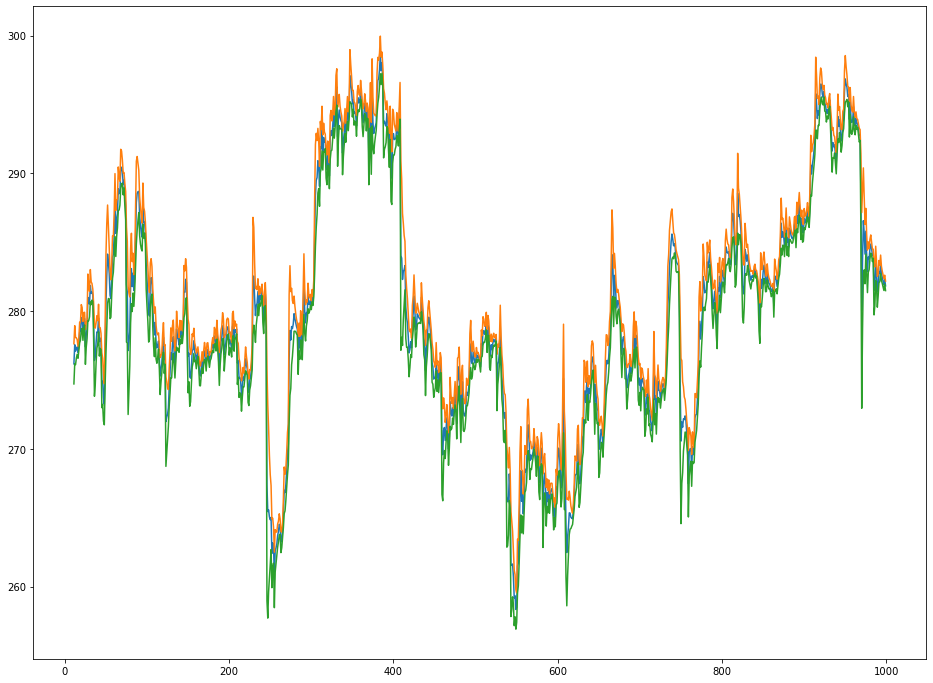

In [91]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [92]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
print(valley_indexes)

[ 31  41  52  68  90  95 105 120 147 157 185 205 220 229 279 291 313 331
 347 360 372 374 384 408 425 434 443 480 484 513 530 555 564 580 584 601
 607 625 643 666 693 710 717 739 785 813 819 828 851 920 950 972]
[ 10  36  48  56  77  94 103 116 123 153 165 188 215 224 255 284 293 322
 338 355 370 373 376 398 419 427 439 460 482 487 526 549 558 578 582 597
 604 611 626 650 684 706 715 720 759 794 816 826 846 863 939 970]


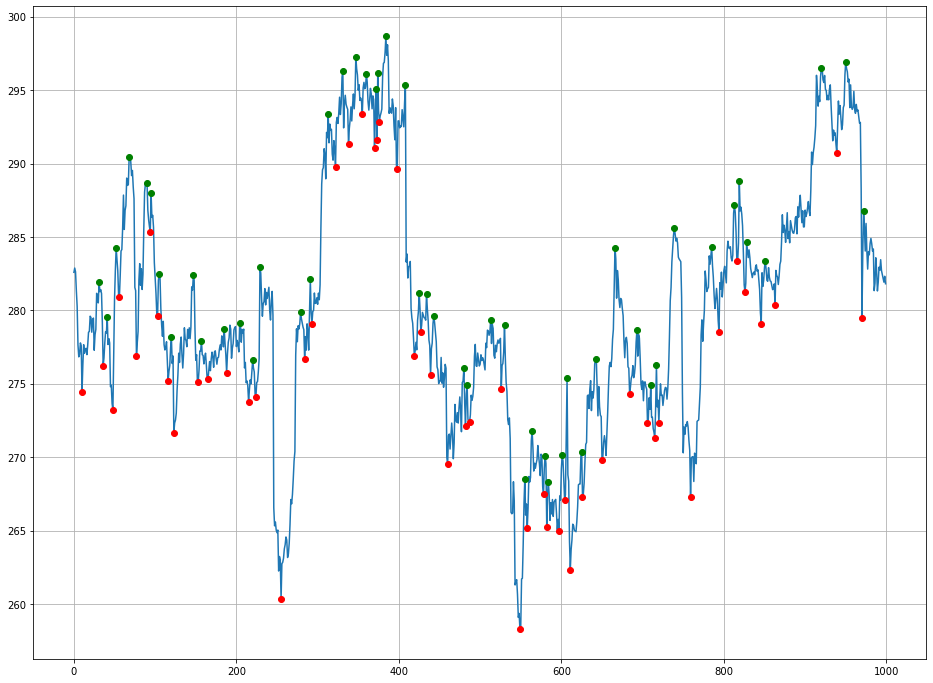

In [93]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [94]:
peak_regions = []
for peak_index in peak_indexes:
    peak_regions.append(peak_index)
    for j in range(min(max(peak_index+1, len(df.close.values) - max(peak_indexes)), 5)):
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    for j in range(min(valley_index+1, len(df.close.values) - max(valley_indexes))):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

62
102


In [95]:
len(peak_regions) - len(peak_indexes)

62

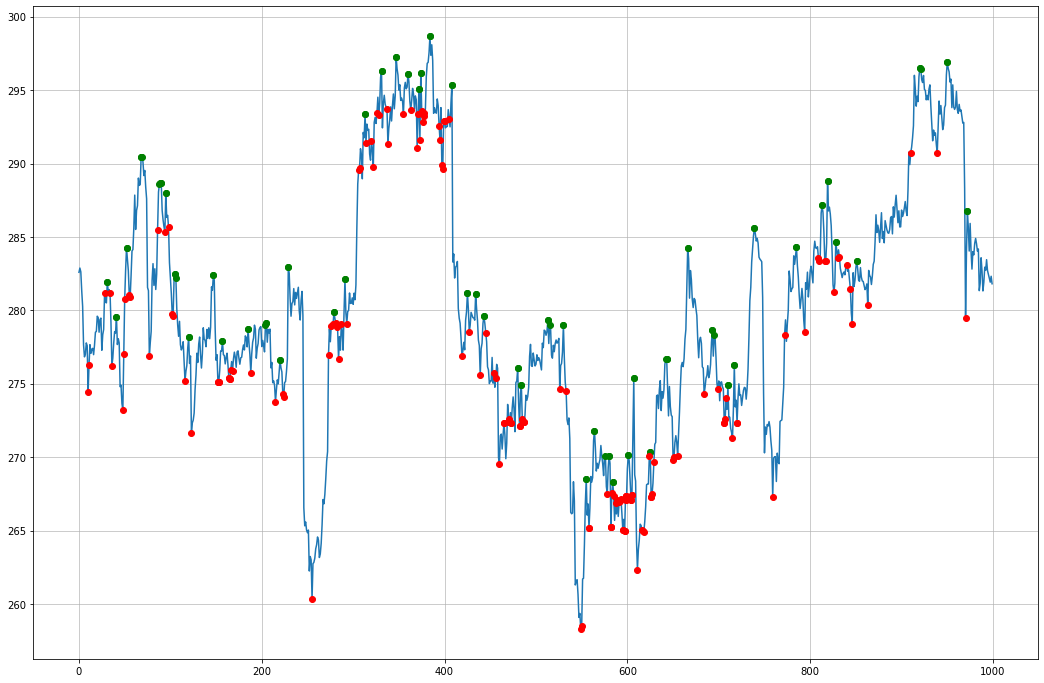

In [96]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")


In [99]:
labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
# print(labels)
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, -1, 0, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 1, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 1, 1, 0, 0, 0, -1, 1, 0, 0, -1, 0, 0, 0, -1, -1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 0, 0, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, -1, 1, 0, -1, -1, 0, -1, 0, 0, -1, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0,

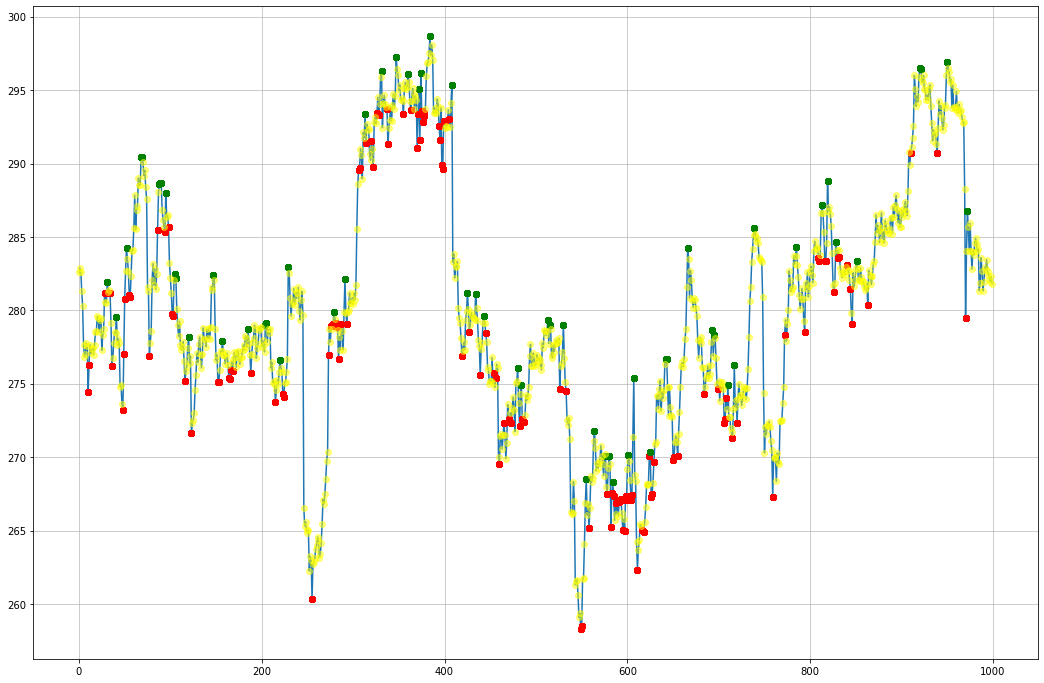

In [108]:
(fig, ax) = plt.subplots(figsize=(18,12))
ax.plot(df.close)
none = []
for i, l in enumerate(labels):
    if l == 1:
        peak_x = peak_regions
        peak_y = df.close.values[peak_regions]
        ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
    elif l == -1:
        valley_x = valley_regions
        valley_y = df.close.values[valley_regions]
        ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
    elif l == 0:
        none.append(i)
none_x = none
none_y = df.close.values[none]
ax.plot(none_x, none_y, marker='o', linestyle="None", color='yellow', alpha=0.5, label="Valleys")        
# ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
# ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")

In [97]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class MarketDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

ImportError: cannot import name 'Dataset' from 'torch' (/home/istrozzi/.local/lib/python3.10/site-packages/torch/__init__.py)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")